In [1]:
from __future__ import print_function, division
import copy
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
import torchvision
print(torch.__version__)
print(torchvision.__version__)

%matplotlib inline

0.4.1
0.2.1


In [2]:
class DeepLesionDataset(Dataset):
    """DeepLesion dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_table(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):


        img_name = os.path.join(self.root_dir,
                                os.path.join(
                                    *self.data_frame.iloc[idx, 0].rsplit('_', 1)
                                ))

        image = io.imread(img_name).astype(np.int32)
#         image = np.expand_dims(image, axis=2)
        image = image - 32768
        image = image.astype(np.int32)
        

        
        img_min = image.min()
        img_max = image.max()
        
        low_bound = -500
        high_bound = 500
        
        
        channel_1 = (((image-img_min)/(low_bound-img_min))*255).clip(0, 255)
        channel_2 = (((image-low_bound)/(high_bound-low_bound))*255).clip(0, 255)
        channel_3 = (((image-high_bound)/(img_max-high_bound))*255).clip(0, 255)

        image = np.zeros((3, image.shape[0], image.shape[1]))
        image[0] = channel_1
        image[1] = channel_2
        image[2] = channel_3
        image = image.astype(np.uint8).transpose(1,2,0)

        bounding_box = np.array(self.data_frame.iloc[idx].Bounding_boxes.split(','))
        bounding_box = bounding_box.astype('float').reshape(-1, 2)
        label = self.data_frame.iloc[idx].Coarse_lesion_type.astype(int) - 1

        c_x =  ((bounding_box[1][0] + bounding_box[0][0])/2) / image.shape[0]
        c_y =  ((bounding_box[1][1] + bounding_box[0][1])/2) / image.shape[1]
        c_hw = (bounding_box[1][0] - bounding_box[0][0]) / image.shape[0]
        c_hh = (bounding_box[1][1] - bounding_box[0][1]) / image.shape[1]
#         c_x1 = bounding_box[0][0] / image.shape[0]
#         c_y1 = bounding_box[0][1] / image.shape[1]
#         c_x2 = bounding_box[1][0] / image.shape[0]
#         c_y2 = bounding_box[1][1] / image.shape[1]

        bounding_box = [c_x, c_y, c_hw, c_hh]
#         bounding_box = [c_x1, c_y1, c_x2, c_y2]
        
        if self.transform:
            image = self.transform(image)
        

        
        return image, torch.FloatTensor([1]), torch.Tensor(bounding_box)

d = DeepLesionDataset('../sets/test_set.tsv', '/media/mark/Data/deeplesion/Images_png',
                     transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                     ])
                     )
print(d[0])
# print(d[0][0].numpy().transpose(1, 2, 0).shape)
# for row in d[0][0].squeeze().numpy():
#     print(row)
# plt.close('all')
# fig,ax = plt.subplots(1, figsize=(5,5))
# fig = plt.figure(figsize=(5, 5))
# _ = plt.imshow(d[0][0].squeeze().numpy())
# plt.show()
# bb_x = d['bounding_box'][0,0]
# bb_y = d['bounding_box'][0,1]
# bb_w = d['bounding_box'][1,0] - d['bounding_box'][0,0] 
# bb_h = d['bounding_box'][0,1] - d['bounding_box'][1,1]
# rect1 = patches.Rectangle((bb_x,bb_y),bb_w,bb_h,linewidth=1,edgecolor='r',facecolor='none')
# ax.add_patch(rect1)

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

In [3]:
torch.tensor([[1., -1.], [1., -1.]]).size()

torch.Size([2, 2])

In [4]:
def imshow(inp, bb, pred, title=None):
    """Imshow for Tensor."""
#     print(inp.numpy().shape)
    inp = inp.numpy().transpose((1, 2, 0))
#     print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(8, 8))
    _ = plt.imshow(inp)
    ax = plt.gca()
    
    ax.add_patch(patches.Rectangle(
        (
            (bb[0] - bb[2]/2) * inp.shape[0],
            (bb[1] - bb[3]/2) * inp.shape[1]
        ),
        (bb[2]) * inp.shape[0],
        (bb[3]) * inp.shape[1],
        linewidth=1,edgecolor='b',facecolor='none'))
    ax.add_patch(patches.Rectangle(
        (
            (pred[0] - pred[2]/2) * inp.shape[0],
            (pred[1] - pred[3]/2) * inp.shape[1]
        ),
        (pred[2]) * inp.shape[0],
        (pred[3]) * inp.shape[1],
        linewidth=1,edgecolor='w',facecolor='none'))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
#     plt.show()

# inputs, classes, bb = next(iter(dataloaders['train']))   

# out = torchvision.utils.make_grid(inputs)
# inputs
# imshow(out)

In [5]:
def visualize_model(model, num_images=6, typ='val'):
    was_training = model.training
    model.eval()
    images_so_far = 0
#     fig = plt.figure(figsize=(4, 4))

    with torch.no_grad():
        for i, (inputs, labels, bb) in enumerate(dataloaders[typ]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            bb = bb.to(device)

            outputs = torch.sigmoid(model(inputs))
#             _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], bb.cpu().data[j], outputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
    best_loss = 1000000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, bb in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                bb = bb.to(device)
                
                 # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
                    outputs = torch.sigmoid(model(inputs))
#                     _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, bb)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()# / inputs.size(0)
                # running_loss += loss.item() loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == bb.data)

            epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, 
#                 epoch_loss, 
#                 epoch_acc))
            print('{} Loss: {:.4f}'.format(
                phase, 
                epoch_loss, 
#                 epoch_acc
            ))

    
#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    visualize_model(model, 16, typ='train')
    return model

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
                     ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
                     ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

                     ]),
}
# DeepLesionDataset('./test_set.tsv', '/media/mark/Data/deeplesion/Images_png')

file_names = {'train': '../sets/train_set_small.tsv', 
              'val': '../sets/validation_set_small.tsv', 
              'test': '../sets/test_set_small.tsv'}

image_datasets = {x: DeepLesionDataset(file_names[x], '/media/mark/Data/deeplesion/Images_png',
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
# class_names = image_datasets['train']['labels']



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [11]:
model_ft = models.resnet152(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)
# model_ft = models.alexnet(pretrained=False)
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[6] = nn.Linear(num_ftrs, 4)


model_ft = model_ft.to(device)

criterion = nn.SmoothL1Loss(reduction='sum')#reduction='sum')

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 24 epochs
exp_lr_scheduler = None#lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

Epoch 0/99
----------
train Loss: 0.0411
val Loss: 0.0494

Epoch 1/99
----------
train Loss: 0.0453
val Loss: 0.0322

Epoch 2/99
----------
train Loss: 0.0379
val Loss: 0.0425

Epoch 3/99
----------
train Loss: 0.0388
val Loss: 0.0272

Epoch 4/99
----------
train Loss: 0.0442
val Loss: 0.0409

Epoch 5/99
----------
train Loss: 0.0449
val Loss: 0.0326

Epoch 6/99
----------
train Loss: 0.0415
val Loss: 0.0270

Epoch 7/99
----------
train Loss: 0.0354
val Loss: 0.0248

Epoch 8/99
----------
train Loss: 0.0415
val Loss: 0.0427

Epoch 9/99
----------
train Loss: 0.0371
val Loss: 0.1158

Epoch 10/99
----------
train Loss: 0.0386
val Loss: 0.0334

Epoch 11/99
----------
train Loss: 0.0340
val Loss: 0.0348

Epoch 12/99
----------
train Loss: 0.0363
val Loss: 0.0335

Epoch 13/99
----------
train Loss: 0.0333
val Loss: 0.0363

Epoch 14/99
----------
train Loss: 0.0360
val Loss: 0.0377

Epoch 15/99
----------
train Loss: 0.0337
val Loss: 0.0406

Epoch 16/99
----------
train Loss: 0.0353
val Loss

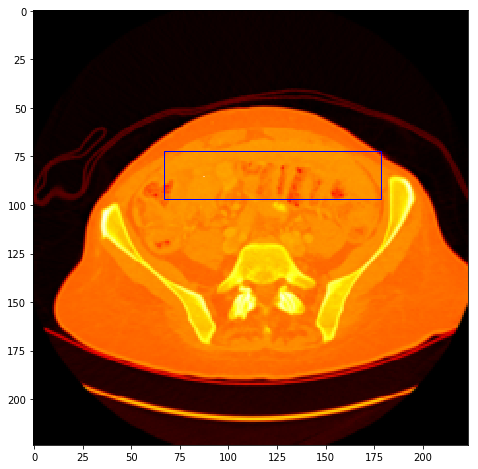

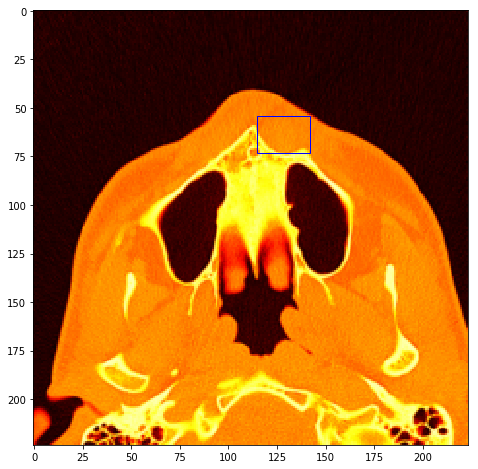

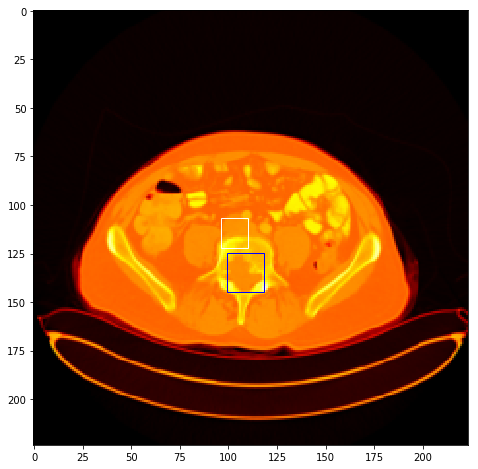

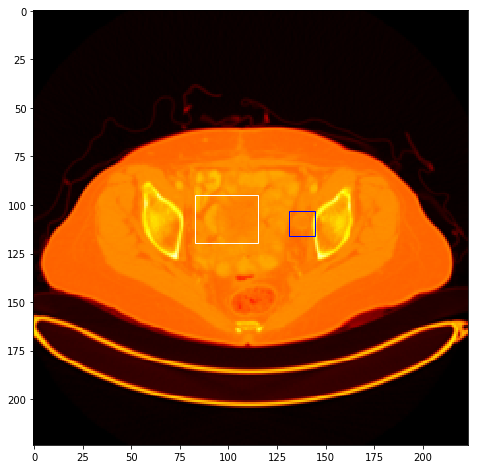

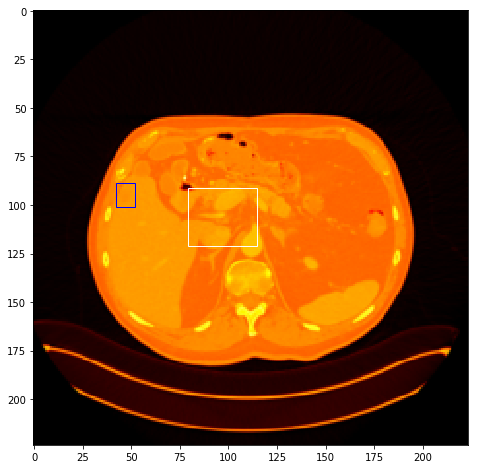

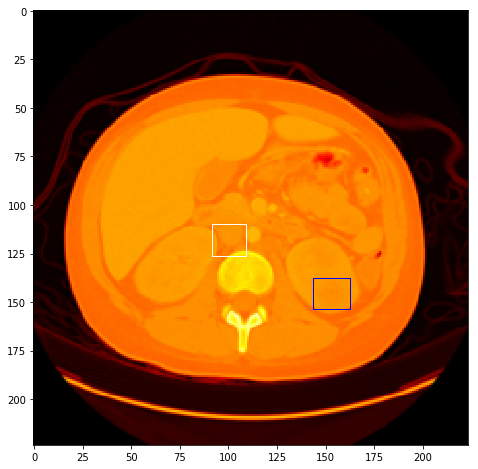

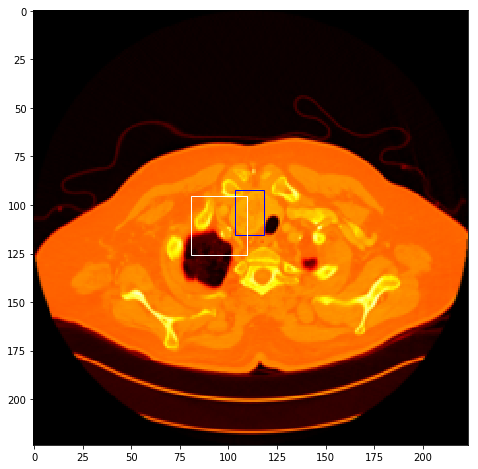

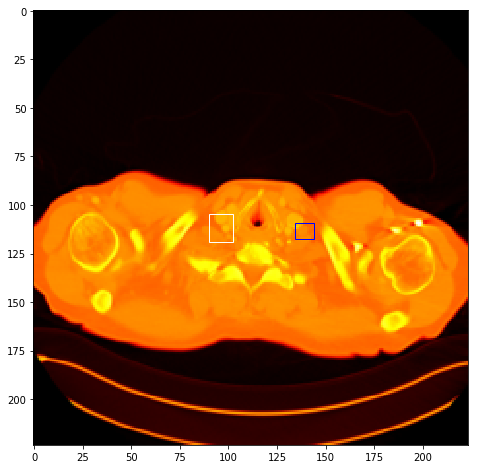

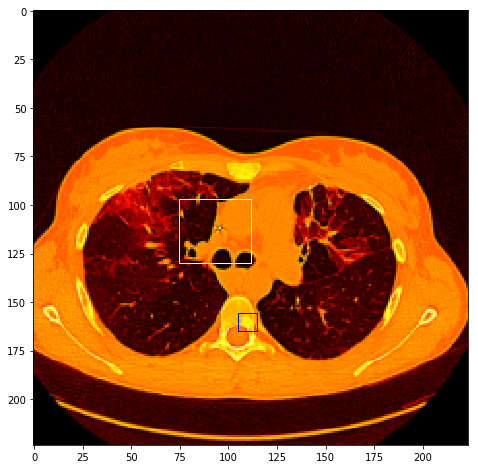

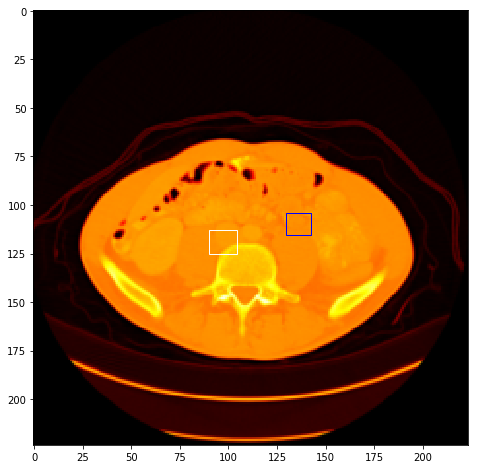

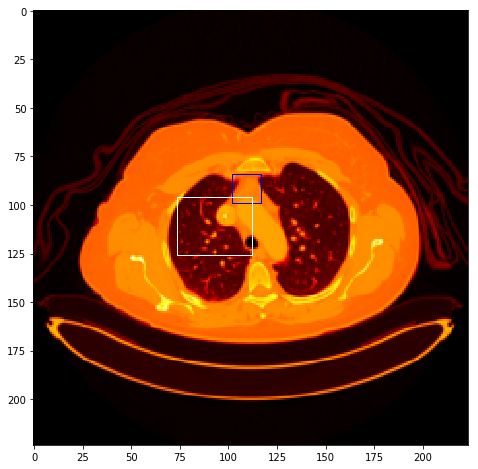

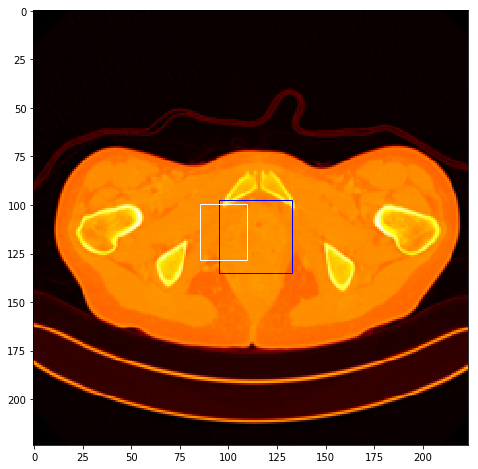

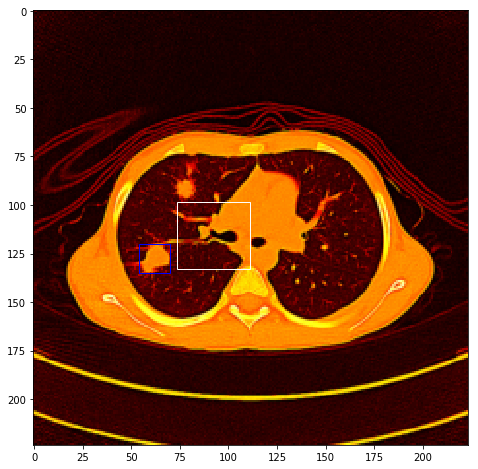

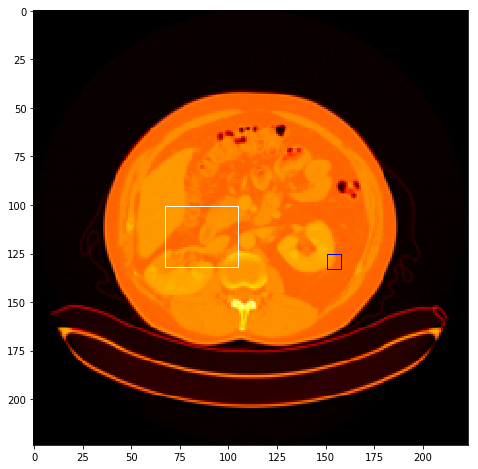

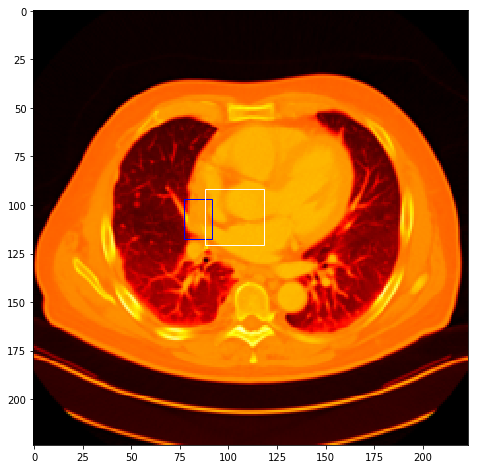

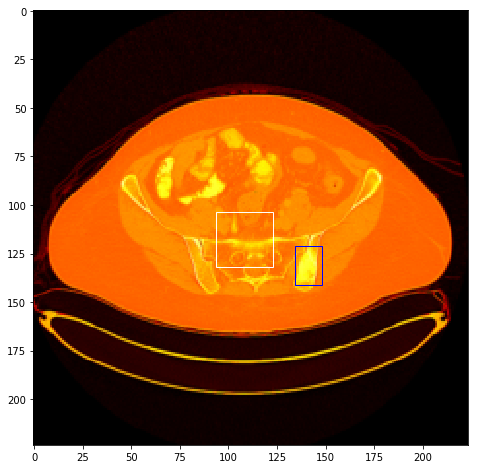

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f9bcc4f6fd0>>
Traceback (most recent call last):
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/mark/miniconda3/en

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

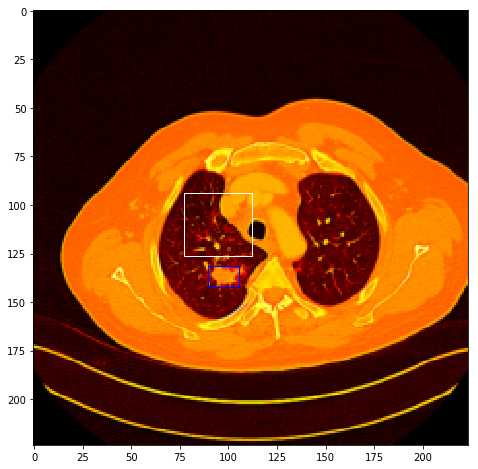

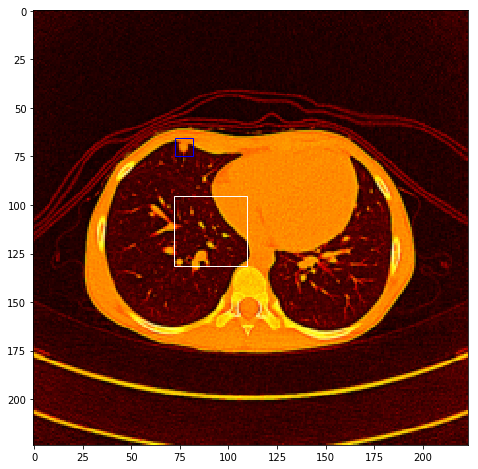

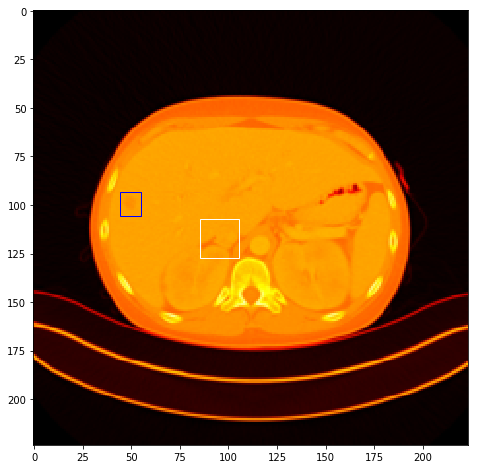

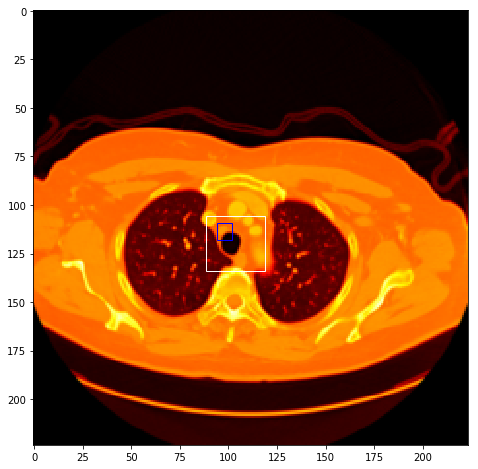

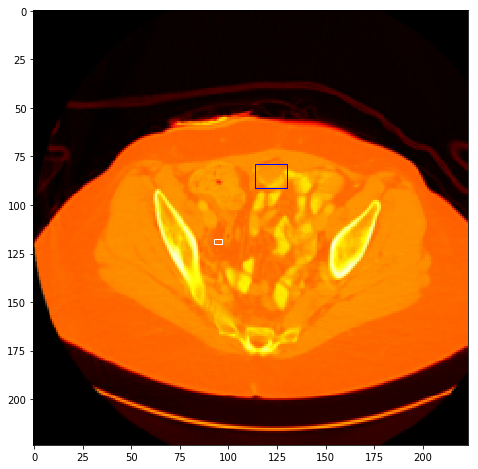

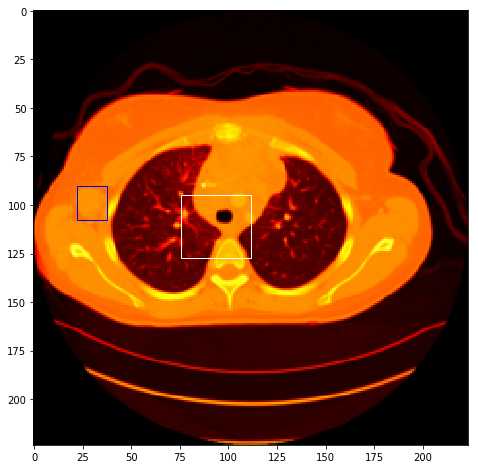

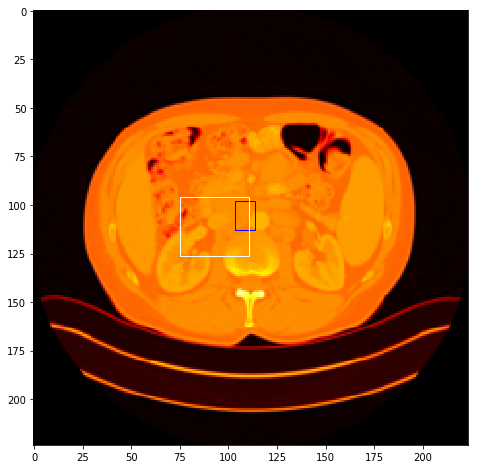

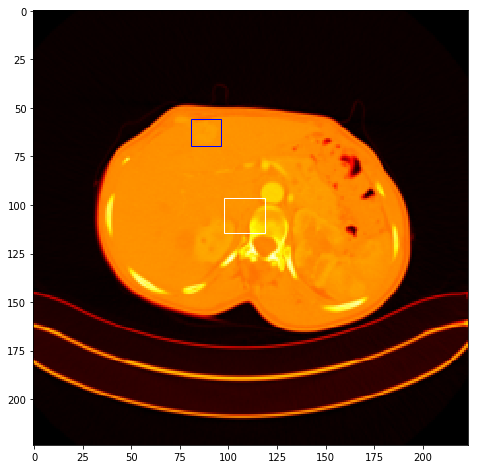

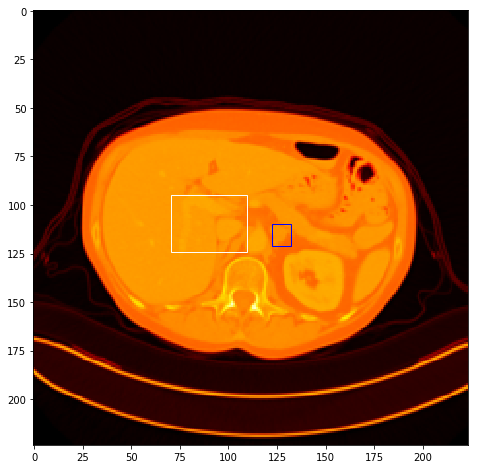

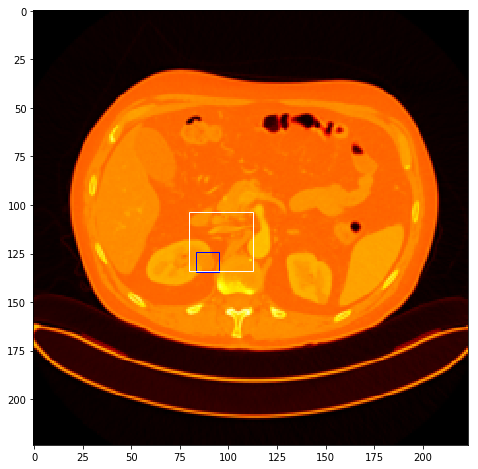

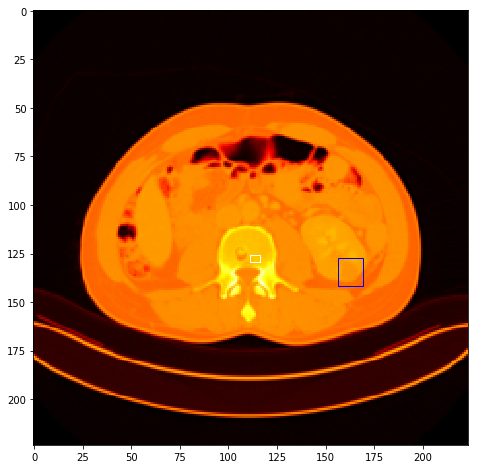

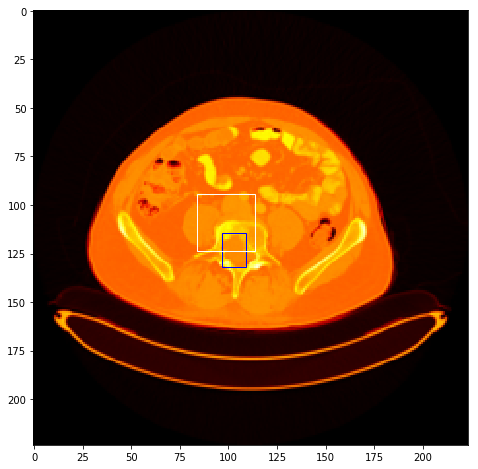

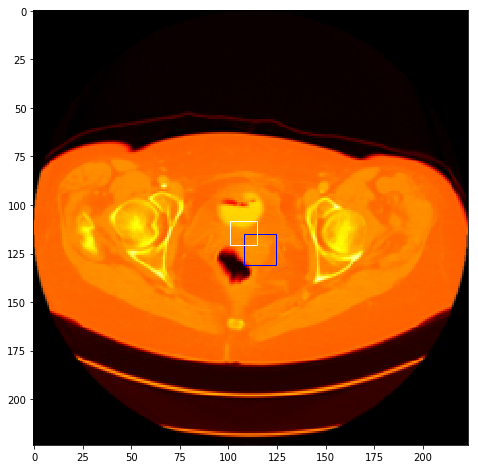

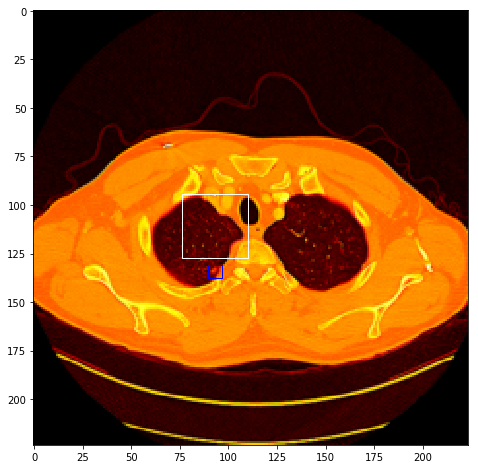

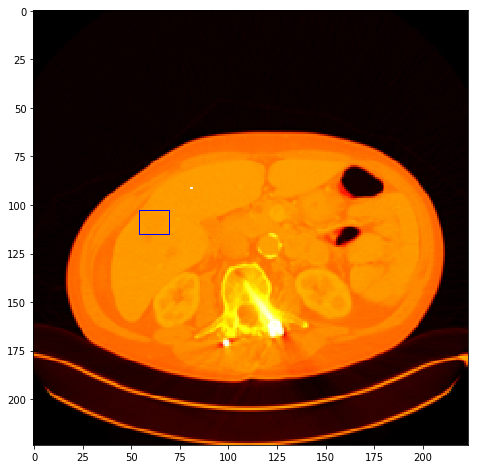

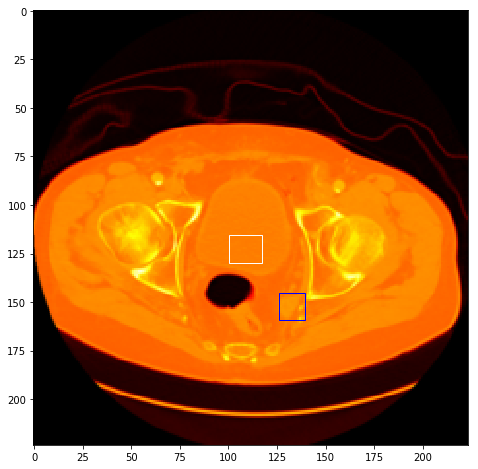

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f9bcc3d00f0>>
Traceback (most recent call last):
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/mark/miniconda3/en

In [13]:
visualize_model(model_ft, 16, typ='val')

In [ ]:
def check_output(model, criterion):
    was_training = model.training
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels, bb) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            bb = bb.to(device)

            outputs = torch.sigmoid(model(inputs))

            loss = criterion(outputs, bb)
            print(outputs)
            print(bb)
            print(loss)
            print(loss.sum(dim=1))
#             print(loss.item())
            return outputs, bb
            break
    model.train(mode=was_training)

o, bb = check_output(model_ft, nn.SmoothL1Loss(reduction='none'))

In [ ]:
for f in model_ft.parameters():
    print(f)

In [ ]:
models.resnet152(pretrained=False)